# Density estimation with Normalizing Flow

## Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which is a function of $\alpha$ and $\beta$ for training and likelihood fitting.

$$
y = e^{- (\alpha + \beta)^2}
$$

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
import matplotlib.pyplot as plt

2023-02-02 22:28:16.411674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

<function matplotlib.pyplot.show(close=None, block=None)>

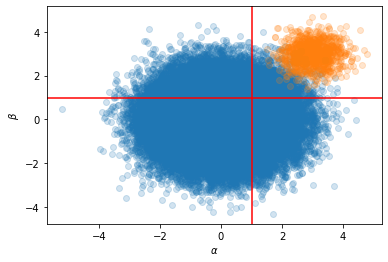

In [15]:
n1 = 100000
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

### Define the training model

In [16]:
def train(data):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[16,16], activation='sigmoid')
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)
    model.compile(optimizer=tf.optimizers.Adam(),loss=lambda _, log_prob: -log_prob)
    batch_size = 512

    # Train
    model.fit(x=data,
              y=np.zeros((len(data),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=20,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(data.shape)
    return samples 

### Generate the 2D gaussian distribution.

In [17]:
samples = train(data)

Epoch 1/20
196/196 [==============================] - 2s 2ms/step - loss: 2.8407
Epoch 2/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8336
Epoch 3/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8335
Epoch 4/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8334
Epoch 5/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8334
Epoch 6/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8335
Epoch 7/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8334
Epoch 8/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8335
Epoch 9/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8334
Epoch 10/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8335
Epoch 11/20
196/196 [==============================] - 0s 2ms/step - loss: 2.8336
Epoch 12/20
196/196 [==============================] - 1s 3ms/step - loss: 2.8333
Epoch 13/20
196/196 [====

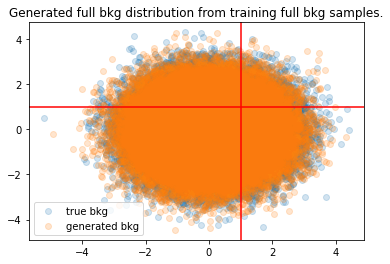

In [18]:
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(x1, x2, alpha = 0.2, label = 'true bkg')
plt.scatter(y1, y2, alpha = 0.2, label = 'generated bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.title("Generated full bkg distribution from training full bkg samples.")
plt.show()

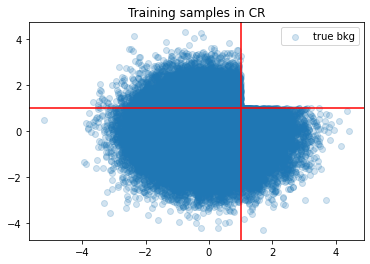

In [19]:
# Train on background distribution in CR
CR_mask = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))

# Plot partial background that's been trained on
x1_CR = data[CR_mask][:,0]
x2_CR = data[CR_mask][:,1]
plt.scatter(x1_CR, x2_CR, alpha = 0.2, label = 'true bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.title("Training samples in CR")
plt.legend()
plt.show()

In [21]:
samples = train(data[CR_mask])

Epoch 1/20
191/191 [==============================] - 2s 2ms/step - loss: 2.8049
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7893
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7888
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7888
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7887
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7887
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7886
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7884
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7885
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7883
Epoch 11/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7885
Epoch 12/20
191/191 [==============================] - 0s 2ms/step - loss: 2.7883
Epoch 13/20
191/191 [====

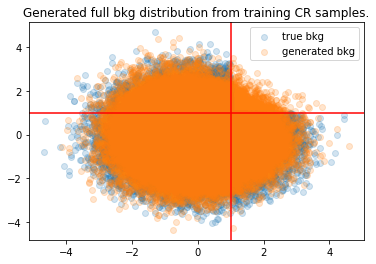

In [22]:
sample2 = samples[:,0]
y1 = sample2[:,0]
y2 = sample2[:,1]
plt.scatter(x5, x6, alpha = 0.2, label = 'true bkg')
plt.scatter(y1, y2, alpha = 0.2, label = 'generated bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.title("Generated full bkg distribution from training CR samples.")
plt.show()

### Generate $y = e^{- (\alpha + \beta)^2}$ with a conditioned density estimator.

Not a good example, because y is deterministic of $\alpha$ and $\beta$.

<function matplotlib.pyplot.show(close=None, block=None)>

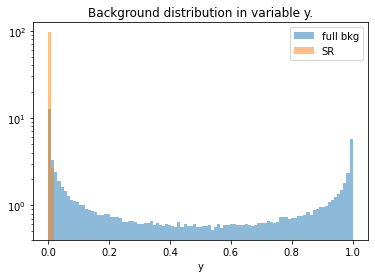

In [44]:
Y = np.exp(-(x1+x2)**2)
mask_SR = (x1 > 1) & (x2 > 1)
bins = np.linspace(0.0, 1.0, 100)
plt.hist(Y, bins, density=True, alpha = 0.5, label='full bkg')
plt.hist(Y[mask_SR], bins, density=True, alpha = 0.5, label='SR')
plt.title("Background distribution in variable y.")
plt.xlabel("y")
plt.yscale("log")
plt.legend()
plt.show

In [45]:
def train_conditioned(data,cond,batch_size=512,learning_rate=1e-3):
    mask_train = np.logical_not((cond[:,0] > 1) & (cond[:,1] > 1))
    mask_gen = (cond[:,0] > 1) & (cond[:,1] > 1)
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(
        params=2, 
        hidden_units=[16,16], 
        event_shape=(data.ndim,),
        conditional=True,
        activation='sigmoid',
        conditional_event_shape=(cond.ndim,)
    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data.ndim]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data.ndim,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond.ndim,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(
        x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_, c_], log_prob_)
    
    # Train
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss=lambda _, log_prob: -log_prob)
    model.fit(x=[data[mask_train], cond[mask_train]],
              y=np.zeros((len(data[mask_train]),0), dtype=np.float32),
              batch_size=batch_size,
              epochs=20,
              shuffle=True,
              verbose=True)
    # Predict the full background distribution
    samples = distribution.sample(
        data[mask_gen].shape[0],
        bijector_kwargs={'conditional_input': cond[mask_gen]}
    )
    return samples 

In [46]:
samples = train_conditioned(Y,data)

Epoch 1/20
191/191 [==============================] - 2s 3ms/step - loss: 0.6341
Epoch 2/20
191/191 [==============================] - 1s 3ms/step - loss: 0.2201
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: -0.1858
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: -2.2640
Epoch 5/20
191/191 [==============================] - 0s 3ms/step - loss: -3.3753
Epoch 6/20
191/191 [==============================] - 1s 3ms/step - loss: -3.7244
Epoch 7/20
191/191 [==============================] - 1s 3ms/step - loss: -3.8818
Epoch 8/20
191/191 [==============================] - 1s 3ms/step - loss: -4.0151
Epoch 9/20
191/191 [==============================] - 1s 3ms/step - loss: -4.0832
Epoch 10/20
191/191 [==============================] - 1s 3ms/step - loss: -4.1846
Epoch 11/20
191/191 [==============================] - 0s 3ms/step - loss: -4.2777
Epoch 12/20
191/191 [==============================] - 1s 3ms/step - loss: -4.3798
Epoch 13/20
191

<function matplotlib.pyplot.show(close=None, block=None)>

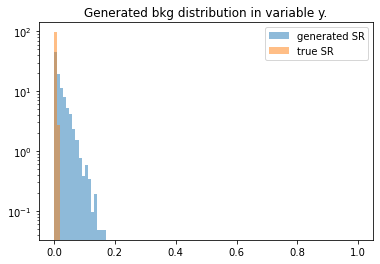

In [47]:
sample2 = np.array(samples[:,0])
bins = np.linspace(0.0, 1, 100)
plt.hist(sample2, bins, density = True, alpha = 0.5, label='generated SR')
plt.hist(Y[mask_SR], bins, density = True, alpha = 0.5, label='true SR')
plt.yscale("log")
plt.title("Generated bkg distribution in variable y.")
plt.legend()
plt.show

### Generate Y = random

<function matplotlib.pyplot.show(close=None, block=None)>

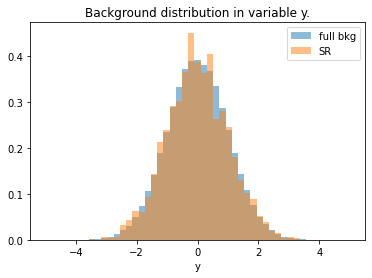

In [32]:
Y = np.random.normal(0, 1, n1).astype(dtype=np.float32)
mask_SR = (x1 > 1) & (x2 > 1)
bins = np.linspace(-5, 5, 50)
plt.hist(Y, bins = bins, density = True, alpha = 0.5, label='full bkg')
plt.hist(Y[mask_SR], bins = bins, density = True, alpha = 0.5, label='SR')
plt.title("Background distribution in variable y.")
plt.xlabel("y")
plt.legend()
plt.show

In [33]:
samples = train_conditioned(Y,data)

Epoch 1/20
191/191 [==============================] - 2s 3ms/step - loss: 1.4529
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4198
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4195
Epoch 4/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4195
Epoch 5/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4193
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4194
Epoch 7/20
191/191 [==============================] - 1s 3ms/step - loss: 1.4193
Epoch 8/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4192
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4191
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4192
Epoch 11/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4192
Epoch 12/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4190
Epoch 13/20
191/191 [====

<function matplotlib.pyplot.show(close=None, block=None)>

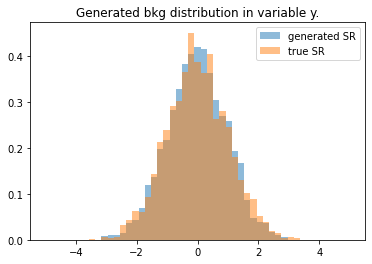

In [35]:
sample2 = np.array(samples[:,0])
bins = np.linspace(-5, 5, 50)
plt.hist(sample2, bins = bins, density = True, alpha = 0.5, label='generated SR')
plt.hist(Y[mask_SR], bins = bins, density = True, alpha = 0.5, label='true SR')
plt.title("Generated bkg distribution in variable y.")
plt.legend()
plt.show

### Generate $ y = N( \mu = k\alpha + q\beta,\sigma = 1)$

<function matplotlib.pyplot.show(close=None, block=None)>

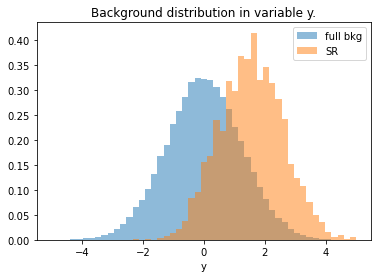

In [38]:
k = 0.5
q = 0.5
Y = np.random.normal(k*x1 + q*x2, 1, n1).astype(dtype=np.float32)
mask_SR = (x1 > 1) & (x2 > 1)
bins = np.linspace(-5, 5, 50)
plt.hist(Y, bins = bins, density = True, alpha = 0.5, label='full bkg')
plt.hist(Y[mask_SR], bins = bins, density = True, alpha = 0.5, label='SR')
plt.title("Background distribution in variable y.")
plt.xlabel("y")
plt.legend()
plt.show

In [39]:
samples = train_conditioned(Y,data)

Epoch 1/20
191/191 [==============================] - 2s 3ms/step - loss: 2.5544
Epoch 2/20
191/191 [==============================] - 0s 3ms/step - loss: 1.8427
Epoch 3/20
191/191 [==============================] - 1s 3ms/step - loss: 1.7361
Epoch 4/20
191/191 [==============================] - 0s 3ms/step - loss: 1.6192
Epoch 5/20
191/191 [==============================] - 0s 3ms/step - loss: 1.5131
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4528
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4351
Epoch 8/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4319
Epoch 9/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4309
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 1.4301
Epoch 11/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4294
Epoch 12/20
191/191 [==============================] - 0s 3ms/step - loss: 1.4288
Epoch 13/20
191/191 [====

<function matplotlib.pyplot.show(close=None, block=None)>

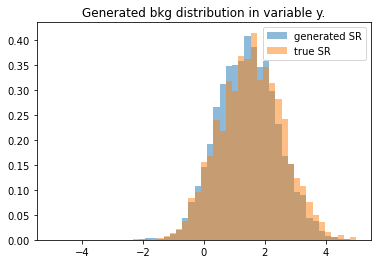

In [40]:
sample2 = np.array(samples[:,0])
bins = np.linspace(-5, 5, 50)
plt.hist(sample2, bins = bins, density = True, alpha = 0.5, label='generated SR')
plt.hist(Y[mask_SR], bins = bins, density = True, alpha = 0.5, label='true SR')
plt.title("Generated bkg distribution in variable y.")
plt.legend()
plt.show